
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)/values/logits: using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_G = tf.placeholder(tf.float32, [None], name='nextQs_G') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return states, next_states, prev_actions, actions, nextQs, nextQs_G, nextQs_D

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The original model loss
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = qfunction(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    qs = tf.sigmoid(Qs) # qt
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, loss

In [10]:
# The new idea of G
def model_output(prev_actions, states,
                 actions, next_states,
                 state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = qfunction(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size)
    
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Returning unmasked nextQs_G, nextQs_D to masked using dones/ends of episodes
    return nextQs_G_unmasked, nextQs_D_unmasked

In [11]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_G, nextQs_D, gamma, 
                prev_actions, states, 
                hidden_size, action_size):
    
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # Bellman equaion: Qs = rt/qt + nextQs_G/D
    qs = tf.sigmoid(Qs) # qt
    targetQs_G = qs + (gamma * nextQs_G)
    targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(Qs - targetQs_G))
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))

    return g_loss, d_loss

In [12]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction loss Tensor for action and next state prediction
    :param g_loss: Qfunction loss Tensor for action and next state prediction
    :param d_loss: Discriminator loss Tensor for reward logits prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        # gq_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=q_vars)
        # gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=[q_vars, d_vars])

    return q_opt, g_opt, d_opt

In [13]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.prev_actions, self.actions, self.nextQs, self.nextQs_G, self.nextQs_D = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss for qfunction
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Output of the Model: nextQs for G and D BUT there are still unmasked with the end of the episodes/dones
        self.nextQs_G_unmasked, self.nextQs_D_unmasked = model_output(
            prev_actions=self.prev_actions, states=self.states,
            actions=self.actions, next_states=self.next_states,
            state_size=state_size, action_size=action_size, 
            hidden_size=hidden_size)
        
        # Loss of the model: calculating the loss for G and D
        self.g_loss, self.d_loss = model_loss2(nextQs_G=self.nextQs_G, nextQs_D=self.nextQs_D, gamma=gamma,
                                               action_size=action_size, hidden_size=hidden_size,
                                               prev_actions=self.prev_actions, states=self.states)
        
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [23]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [25]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #print(prev_actions.shape, states.shape, actions.shape, next_states.shape, dones.shape)
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_G_unmasked, nextQs_D_unmasked = sess.run([model.nextQs_G_unmasked,
                                                             model.nextQs_D_unmasked], feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_G_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_G_masked = np.multiply(nextQs_G_unmasked[0], dones_mask)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_G = np.max(nextQs_G_masked, axis=1)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # D(At-1, St)= Qs and qs = tf.sigmoid(Qs)
            # NextQs/Qt+1 are given both:
            # targetQs = qs + gamma * nextQs_G
            # targetQs = qs + gamma * nextQs_D
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs,
                         model.nextQs_G: nextQs_G,
                         model.nextQs_D: nextQs_D}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            ################################################################################
            ################################################################################
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 35.0 Training q_loss: 1.3104 Training g_loss: 54.5162 Training d_loss: 2.7160 Explore P: 0.9965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 18.0 Training q_loss: 3.1405 Training g_loss: 3837.5439 Training d_loss: 15.9769 Explore P: 0.9948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 14.0 Training q_loss: 6.4102 Training g_loss: 38390.8789 Training d_loss: 30.4791 Explore P: 0.9934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 21.0 Training q_loss: 41.5066 Training g_loss

-------------------------------------------------------------------------------
Episode: 30 Total reward: 8.0 Training q_loss: 96.4811 Training g_loss: 125818424.0000 Training d_loss: 1021.5121 Explore P: 0.9298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 37.0 Training q_loss: 182.5543 Training g_loss: 179607024.0000 Training d_loss: 1353.9182 Explore P: 0.9264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 26.0 Training q_loss: 157.8968 Training g_loss: 166721232.0000 Training d_loss: 1043.4429 Explore P: 0.9240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 27.0 Training 

-------------------------------------------------------------------------------
Episode: 58 Total reward: 34.0 Training q_loss: 2208.6472 Training g_loss: 251170783232.0000 Training d_loss: 78039.8203 Explore P: 0.8678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 59 Total reward: 17.0 Training q_loss: 3701.5784 Training g_loss: 447362465792.0000 Training d_loss: 137854.1250 Explore P: 0.8664
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 60 Total reward: 18.0 Training q_loss: 2568.5247 Training g_loss: 250555695104.0000 Training d_loss: 147935.4375 Explore P: 0.8648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total rew

-------------------------------------------------------------------------------
Episode: 86 Total reward: 57.0 Training q_loss: 8022.1211 Training g_loss: 46844335882240.0000 Training d_loss: 2142075.0000 Explore P: 0.8137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 87 Total reward: 57.0 Training q_loss: 8435.1670 Training g_loss: 2788529537024.0000 Training d_loss: 1852787.1250 Explore P: 0.8091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 88 Total reward: 25.0 Training q_loss: 7185.6011 Training g_loss: 33943439015936.0000 Training d_loss: 2569709.2500 Explore P: 0.8071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 89 

-------------------------------------------------------------------------------
Episode: 113 Total reward: 30.0 Training q_loss: 748276.0000 Training g_loss: 405307164551282688.0000 Training d_loss: 167868912.0000 Explore P: 0.7269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 114 Total reward: 54.0 Training q_loss: 375376.3750 Training g_loss: 468829627779907584.0000 Training d_loss: 111316672.0000 Explore P: 0.7231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 115 Total reward: 48.0 Training q_loss: 411280.8750 Training g_loss: 504579320644108288.0000 Training d_loss: 155431472.0000 Explore P: 0.7197
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 140 Total reward: 19.0 Training q_loss: 16533304.0000 Training g_loss: 384555687150469775360.0000 Training d_loss: 4246456064.0000 Explore P: 0.6284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 73.0 Training q_loss: 40322392.0000 Training g_loss: 189144903939142975488.0000 Training d_loss: 7153370624.0000 Explore P: 0.6239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 70.0 Training q_loss: 11508851.0000 Training g_loss: 547568190369004781568.0000 Training d_loss: 7678966272.0000 Explore P: 0.6196
-------------------------------------------------------------------------------
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 199.0 Training q_loss: 58094576.0000 Training g_loss: 142309487819660181110784.0000 Training d_loss: 35462332416.0000 Explore P: 0.4718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 70.0 Training q_loss: 293542272.0000 Training g_loss: 207540840794393835208704.0000 Training d_loss: 94919892992.0000 Explore P: 0.4686
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 198.0 Training q_loss: 79052560.0000 Training g_loss: 218956763288236172771328.0000 Training d_loss: 43718369280.0000 Explore P: 0.4596
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 192 Total reward: 199.0 Training q_loss: 84033088.0000 Training g_loss: 143026568966728620965888.0000 Training d_loss: 75973640192.0000 Explore P: 0.3095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 193 Total reward: 199.0 Training q_loss: 134723184.0000 Training g_loss: 63781905463461478924288.0000 Training d_loss: 47621992448.0000 Explore P: 0.3036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 194 Total reward: 199.0 Training q_loss: 227188576.0000 Training g_loss: 76150240199300874240000.0000 Training d_loss: 44274655232.0000 Explore P: 0.2978
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 218 Total reward: 199.0 Training q_loss: 337043840.0000 Training g_loss: 640896637290724458496.0000 Training d_loss: 2058434816.0000 Explore P: 0.1969
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 219 Total reward: 199.0 Training q_loss: 245490640.0000 Training g_loss: 555003598169421381632.0000 Training d_loss: 3489733376.0000 Explore P: 0.1933
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 220 Total reward: 199.0 Training q_loss: 383534240.0000 Training g_loss: 511903129388695158784.0000 Training d_loss: 4569245184.0000 Explore P: 0.1896
-------------------------------------------------------------------------------
----------------------------------------

-------------------------------------------------------------------------------
Episode: 245 Total reward: 105.0 Training q_loss: 377257120.0000 Training g_loss: 31531101769034629120.0000 Training d_loss: 539019840.0000 Explore P: 0.1432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 108.0 Training q_loss: 173032832.0000 Training g_loss: 20442432444913680384.0000 Training d_loss: 834165248.0000 Explore P: 0.1418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 102.0 Training q_loss: 38473300.0000 Training g_loss: 36015653456965533696.0000 Training d_loss: 8052457.5000 Explore P: 0.1405
-------------------------------------------------------------------------------
-------------------------------------------------

-------------------------------------------------------------------------------
Episode: 271 Total reward: 149.0 Training q_loss: 76995320.0000 Training g_loss: 33787717443649536.0000 Training d_loss: 105100072.0000 Explore P: 0.1098
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 117.0 Training q_loss: 169489216.0000 Training g_loss: 801889498177732608.0000 Training d_loss: 24857304.0000 Explore P: 0.1086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 273 Total reward: 130.0 Training q_loss: 160795392.0000 Training g_loss: 631797935578808320.0000 Training d_loss: 802140.6250 Explore P: 0.1073
-------------------------------------------------------------------------------
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 298 Total reward: 199.0 Training q_loss: 1649174656.0000 Training g_loss: 2059246497693696.0000 Training d_loss: 2356581.5000 Explore P: 0.0738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 199.0 Training q_loss: 1317920768.0000 Training g_loss: 5437217606467584.0000 Training d_loss: 49237.9766 Explore P: 0.0725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 199.0 Training q_loss: 1880093824.0000 Training g_loss: 7680515532390400.0000 Training d_loss: 3476133.5000 Explore P: 0.0713
-------------------------------------------------------------------------------
---------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 325 Total reward: 199.0 Training q_loss: 953060224.0000 Training g_loss: 142405563056128.0000 Training d_loss: 28028.9336 Explore P: 0.0476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 199.0 Training q_loss: 1224090624.0000 Training g_loss: 323718697975808.0000 Training d_loss: 23605.0449 Explore P: 0.0468
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 199.0 Training q_loss: 1032529728.0000 Training g_loss: 77683048316928.0000 Training d_loss: 59272.0312 Explore P: 0.0461
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 352 Total reward: 199.0 Training q_loss: 67708064.0000 Training g_loss: 1429441347584.0000 Training d_loss: 29.4481 Explore P: 0.0325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 353 Total reward: 199.0 Training q_loss: 133612448.0000 Training g_loss: 1117443719168.0000 Training d_loss: 37.7968 Explore P: 0.0321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 354 Total reward: 199.0 Training q_loss: 34465816.0000 Training g_loss: 66740797046784.0000 Training d_loss: 77.6601 Explore P: 0.0317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 

-------------------------------------------------------------------------------
Episode: 379 Total reward: 121.0 Training q_loss: 119712048.0000 Training g_loss: 3146882220032.0000 Training d_loss: 144.6174 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 380 Total reward: 106.0 Training q_loss: 41750848.0000 Training g_loss: 15886211612672.0000 Training d_loss: 30.9265 Explore P: 0.0248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 122.0 Training q_loss: 34855548.0000 Training g_loss: 2475537203200.0000 Training d_loss: 46.8916 Explore P: 0.0246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode:

-------------------------------------------------------------------------------
Episode: 406 Total reward: 199.0 Training q_loss: 88414048.0000 Training g_loss: 949635973120.0000 Training d_loss: 18.8465 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 407 Total reward: 199.0 Training q_loss: 55699512.0000 Training g_loss: 9396374528.0000 Training d_loss: 33.7588 Explore P: 0.0201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 199.0 Training q_loss: 147080256.0000 Training g_loss: 47391025659904.0000 Training d_loss: 16.4008 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 

-------------------------------------------------------------------------------
Episode: 434 Total reward: 62.0 Training q_loss: 15104323.0000 Training g_loss: 71831297982464.0000 Training d_loss: 3.6844 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 199.0 Training q_loss: 61526772.0000 Training g_loss: 3015088013312.0000 Training d_loss: 49.9542 Explore P: 0.0163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 199.0 Training q_loss: 112686944.0000 Training g_loss: 61880668160.0000 Training d_loss: 0.9256 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 437 T

-------------------------------------------------------------------------------
Episode: 462 Total reward: 18.0 Training q_loss: 142595232.0000 Training g_loss: 3747799105536.0000 Training d_loss: 58.3311 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 111.0 Training q_loss: 73406872.0000 Training g_loss: 5767236681728.0000 Training d_loss: 72.9950 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 17.0 Training q_loss: 79570000.0000 Training g_loss: 8549482627072.0000 Training d_loss: 37.5852 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465

-------------------------------------------------------------------------------
Episode: 490 Total reward: 199.0 Training q_loss: 89968056.0000 Training g_loss: 192442417152.0000 Training d_loss: 12.1240 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 491 Total reward: 199.0 Training q_loss: 123996080.0000 Training g_loss: 59955625328640.0000 Training d_loss: 21.4972 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 492 Total reward: 199.0 Training q_loss: 59936036.0000 Training g_loss: 67675840512.0000 Training d_loss: 0.9737 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 

-------------------------------------------------------------------------------
Episode: 518 Total reward: 199.0 Training q_loss: 65883084.0000 Training g_loss: 11294799.0000 Training d_loss: 0.0759 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 519 Total reward: 199.0 Training q_loss: 26671636.0000 Training g_loss: 135284432896.0000 Training d_loss: 14.8314 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 199.0 Training q_loss: 54447952.0000 Training g_loss: 775476543488.0000 Training d_loss: 0.1417 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 521 Total r

-------------------------------------------------------------------------------
Episode: 546 Total reward: 199.0 Training q_loss: 15816417.0000 Training g_loss: 3648366837760.0000 Training d_loss: 86.2300 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 547 Total reward: 199.0 Training q_loss: 122522632.0000 Training g_loss: 7200432128.0000 Training d_loss: 0.7186 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 548 Total reward: 199.0 Training q_loss: 33347276.0000 Training g_loss: 1792111280128.0000 Training d_loss: 1.3697 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 To

-------------------------------------------------------------------------------
Episode: 574 Total reward: 199.0 Training q_loss: 19699878.0000 Training g_loss: 1024799145984.0000 Training d_loss: 67.4650 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 575 Total reward: 199.0 Training q_loss: 23311486.0000 Training g_loss: 688490217472.0000 Training d_loss: 81.0819 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 576 Total reward: 199.0 Training q_loss: 25610086.0000 Training g_loss: 752025665536.0000 Training d_loss: 11.4341 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 577 

-------------------------------------------------------------------------------
Episode: 602 Total reward: 199.0 Training q_loss: 63446972.0000 Training g_loss: 220461858816.0000 Training d_loss: 31.5358 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 199.0 Training q_loss: 42240856.0000 Training g_loss: 130143002624.0000 Training d_loss: 22.8429 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 604 Total reward: 199.0 Training q_loss: 71010472.0000 Training g_loss: 103368007680.0000 Training d_loss: 30.4242 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 605 T

-------------------------------------------------------------------------------
Episode: 630 Total reward: 199.0 Training q_loss: 13345149.0000 Training g_loss: 104431353856.0000 Training d_loss: 0.2178 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 631 Total reward: 111.0 Training q_loss: 8578569.0000 Training g_loss: 183311482880.0000 Training d_loss: 17.2383 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 632 Total reward: 199.0 Training q_loss: 14426764.0000 Training g_loss: 694405279252480.0000 Training d_loss: 50.0451 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 633 

-------------------------------------------------------------------------------
Episode: 658 Total reward: 199.0 Training q_loss: 19591424.0000 Training g_loss: 40754720768.0000 Training d_loss: 22.1616 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 659 Total reward: 199.0 Training q_loss: 41844100.0000 Training g_loss: 98971598848.0000 Training d_loss: 0.3502 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 660 Total reward: 164.0 Training q_loss: 33682536.0000 Training g_loss: 260404838400.0000 Training d_loss: 107.5591 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 661 Tot

-------------------------------------------------------------------------------
Episode: 686 Total reward: 199.0 Training q_loss: 15283999.0000 Training g_loss: 90582245376.0000 Training d_loss: 40.4321 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 199.0 Training q_loss: 30546760.0000 Training g_loss: 58617954304.0000 Training d_loss: 11.6924 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 199.0 Training q_loss: 46927452.0000 Training g_loss: 135039710920704.0000 Training d_loss: 6.1586 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 689 T

-------------------------------------------------------------------------------
Episode: 714 Total reward: 138.0 Training q_loss: 13317907.0000 Training g_loss: 32773003264.0000 Training d_loss: 33.9074 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 715 Total reward: 199.0 Training q_loss: 80930920.0000 Training g_loss: 71685685248.0000 Training d_loss: 34.2015 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 55.0 Training q_loss: 23537418.0000 Training g_loss: 74198040576.0000 Training d_loss: 22.5055 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total

-------------------------------------------------------------------------------
Episode: 742 Total reward: 199.0 Training q_loss: 34773632.0000 Training g_loss: 28059889664.0000 Training d_loss: 12.6505 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 743 Total reward: 199.0 Training q_loss: 10911626.0000 Training g_loss: 3702106112.0000 Training d_loss: 0.2003 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 744 Total reward: 199.0 Training q_loss: 27401582.0000 Training g_loss: 38327377920.0000 Training d_loss: 27.9887 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 745 Total 

-------------------------------------------------------------------------------
Episode: 770 Total reward: 153.0 Training q_loss: 15593503.0000 Training g_loss: 11939251200.0000 Training d_loss: 19.1087 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 771 Total reward: 199.0 Training q_loss: 1660398.3750 Training g_loss: 122426777600.0000 Training d_loss: 43.5563 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 772 Total reward: 138.0 Training q_loss: 5026822.0000 Training g_loss: 4905892315136.0000 Training d_loss: 86.7009 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 773 Tot

-------------------------------------------------------------------------------
Episode: 798 Total reward: 33.0 Training q_loss: 8785779.0000 Training g_loss: 71920854761472.0000 Training d_loss: 810.1810 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 10.0 Training q_loss: 153637.6562 Training g_loss: 34695110721536.0000 Training d_loss: 464.9642 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 199.0 Training q_loss: 33817564.0000 Training g_loss: 2280499183616.0000 Training d_loss: 97.6802 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801

-------------------------------------------------------------------------------
Episode: 826 Total reward: 95.0 Training q_loss: 4385916.0000 Training g_loss: 740980555776.0000 Training d_loss: 28.9454 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 827 Total reward: 48.0 Training q_loss: 7898728.5000 Training g_loss: 103503527936.0000 Training d_loss: 72.1305 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 126.0 Training q_loss: 28846994.0000 Training g_loss: 92517097472.0000 Training d_loss: 29.2720 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total 

-------------------------------------------------------------------------------
Episode: 854 Total reward: 8.0 Training q_loss: 4000457.2500 Training g_loss: 182449076862713856.0000 Training d_loss: 3857.9895 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 11.0 Training q_loss: 214145440.0000 Training g_loss: 235931023244787712.0000 Training d_loss: 40018.1094 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 10.0 Training q_loss: 6022016.0000 Training g_loss: 378319720366997504.0000 Training d_loss: 6788.5024 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 882 Total reward: 8.0 Training q_loss: 2149160192.0000 Training g_loss: 356937538357480652800.0000 Training d_loss: 5382827.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 10.0 Training q_loss: 7014534144.0000 Training g_loss: 427884115477959540736.0000 Training d_loss: 17248912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 9.0 Training q_loss: 56895712.0000 Training g_loss: 535369592643946283008.0000 Training d_loss: 596433.3125 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 908 Total reward: 103.0 Training q_loss: 30355922.0000 Training g_loss: 380631011181448921088.0000 Training d_loss: 56344104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 909 Total reward: 23.0 Training q_loss: 20735550.0000 Training g_loss: 196459435829248393216.0000 Training d_loss: 5863623.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 910 Total reward: 13.0 Training q_loss: 19865326.0000 Training g_loss: 305312916566421012480.0000 Training d_loss: 2467313.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 935 Total reward: 12.0 Training q_loss: 145483984.0000 Training g_loss: 111690449435253276672.0000 Training d_loss: 32694888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 10.0 Training q_loss: 13483329.0000 Training g_loss: 31766799678634459136.0000 Training d_loss: 2503567.7500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 12.0 Training q_loss: 195287104.0000 Training g_loss: 102501751597092044800.0000 Training d_loss: 90436136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 962 Total reward: 199.0 Training q_loss: 1322327168.0000 Training g_loss: 2463478342020497408.0000 Training d_loss: 1185355.6250 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 963 Total reward: 199.0 Training q_loss: 354058080.0000 Training g_loss: 94805939860799488.0000 Training d_loss: 868706.1250 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 199.0 Training q_loss: 479214304.0000 Training g_loss: 96275634719817728.0000 Training d_loss: 3581706.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 989 Total reward: 199.0 Training q_loss: 319135808.0000 Training g_loss: 17806494007296.0000 Training d_loss: 487.3592 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 990 Total reward: 199.0 Training q_loss: 586893824.0000 Training g_loss: 16181771632640.0000 Training d_loss: 3695.1616 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 199.0 Training q_loss: 677553664.0000 Training g_loss: 5739094474752.0000 Training d_loss: 1973.5385 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

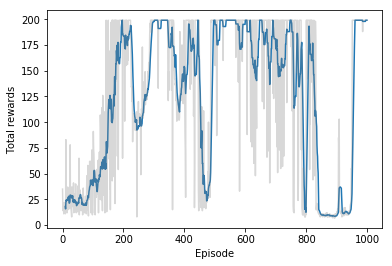

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

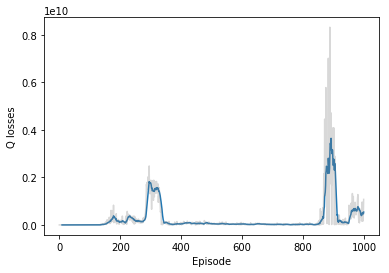

In [29]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

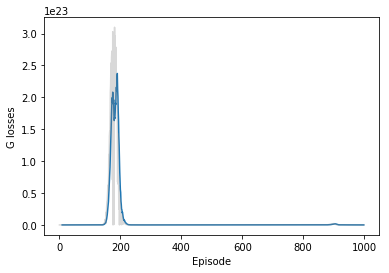

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

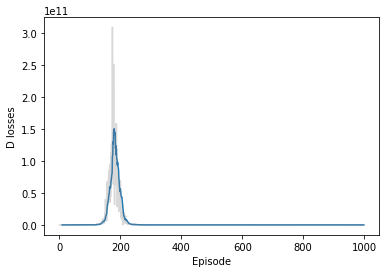

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [35]:
# # Closing the env
# # WARNING: If you close, you can NOT restart again!!!!!!
# env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.